# 1、pre work

## 1.1. set GPU

In [ ]:
import tensorflow as tf）

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  
    tf.config.set_visible_devices([gpus[0]],"GPU")

## 1.2. import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
import os,PIL,pathlib


import numpy as np
np.random.seed(1)


import tensorflow as tf
tf.random.set_seed(1)

from tensorflow import keras
from tensorflow.keras import layers,models

In [ ]:
data_dir = "./drive/MyDrive/Colab Notebooks/Hand Gestures"

data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('drive/MyDrive/Colab Notebooks/Hand Gestures')

## 1.3. data check

In [ ]:
image_count = len(list(data_dir.glob('*/*')))

print("total photo amount：",image_count)

total photo amount： 259


# 2、pre process data

## 2.1. data loading

use`image_dataset_from_directory`Load the data from the disk into the`tf.data.Dataset`

In [ ]:
batch_size = 8
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.5,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

In [ ]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Labels for datasets can be exported via class_names. The labels will correspond to the catalogue names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['.ipynb_checkpoints', 'Paper', 'Rock', 'Scissors']


## 2.2. data visualisation

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


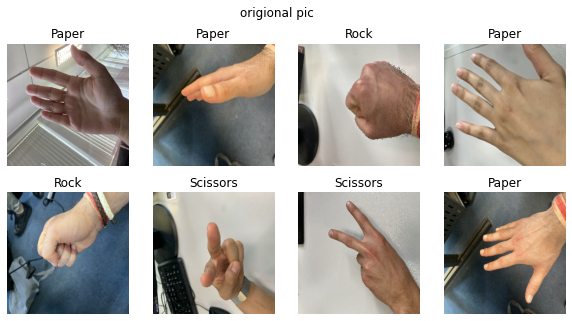

In [ ]:
plt.figure(figsize=(10, 5)) 
plt.suptitle("origional pic")

for images, labels in train_ds.take(1):
    for i in range(8):
        
        ax = plt.subplot(2, 4, i + 1)  

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


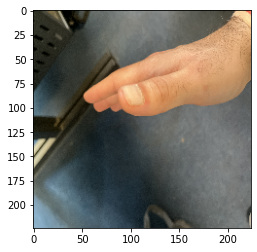

In [ ]:
plt.imshow(images[1].numpy().astype("uint8"))

## 2.3. check the data again

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(8, 224, 224, 3)
(8,)


## 2.4. Configuring data sets

> 缩进块



- **shuffle()** ： Disrupting data，
- **prefetch()** ：Pre-fetching data to speed up operations，
- **cache()** ：Cache data sets into memory to speed up operation

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

![](pictures/13-2.png)

# 3、Inception V3

In [ ]:
#=============================================================
#                  Inception V3 网络                          
#=============================================================

from tensorflow.keras.models import Model
from tensorflow.keras        import layers
from tensorflow.keras.layers import Activation,Dense,Input,BatchNormalization,Conv2D,AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,MaxPooling2D


def conv2d_bn(x,filters,num_row,num_col,padding='same',strides=(1, 1),name=None):
    
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
        
    x = Conv2D(filters,(num_row, num_col),strides=strides,padding=padding,use_bias=False,name=conv_name)(x)
    x = BatchNormalization(scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x


def InceptionV3(input_shape=[224,224,3],classes=1000):

    img_input = Input(shape=input_shape)

    x = conv2d_bn(img_input, 32, 3, 3, strides=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x,  80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    #================================#
    #         Block1 35x35
    #================================#
    # Block1 part1
    # 35 x 35 x 192 -> 35 x 35 x 256
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],axis=3,name='mixed0')

    # Block1 part2
    # 35 x 35 x 256 -> 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],axis=3,name='mixed1')

    # Block1 part3
    # 35 x 35 x 288 -> 35 x 35 x 288
    branch1x1 = conv2d_bn(x, 64, 1, 1)

    branch5x5 = conv2d_bn(x, 48, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1, 1)
    x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],axis=3,name='mixed2')

    #================================#
    #          Block2 17x17
    #================================#
    # Block2 part1
    # 35 x 35 x 288 -> 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, strides=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate([branch3x3, branch3x3dbl, branch_pool], axis=3, name='mixed3')

    # Block2 part2
    # 17 x 17 x 768 -> 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    
    x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],axis=3,name='mixed4')

    # Block2 part3 and part4
    # 17 x 17 x 768 -> 17 x 17 x 768 -> 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],axis=3,name='mixed' + str(5 + i))

    # Block2 part5
    # 17 x 17 x 768 -> 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 192, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = layers.concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],axis=3,name='mixed7')

    #================================#
    #         Block3 8x8
    #================================#
    # Block3 part1
    # 17 x 17 x 768 -> 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1)
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,strides=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = layers.concatenate([branch3x3, branch7x7x3, branch_pool], axis=3, name='mixed8')

    # Block3 part2 part3
    # 8 x 8 x 1280 -> 8 x 8 x 2048 -> 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = layers.concatenate(
            [branch3x3_1, branch3x3_2], axis=3, name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = layers.concatenate([branch3x3dbl_1, branch3x3dbl_2], axis=3)

        branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = layers.concatenate([branch1x1, branch3x3, branch3x3dbl, branch_pool],axis=3,name='mixed' + str(9 + i))
    
    # 平均池化后全连接。
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, activation='softmax', name='predictions')(x)

    inputs = img_input

    model = Model(inputs, x, name='inception_v3')

    return model

model = InceptionV3()
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# import tensorflow as tf

# model_2 = tf.keras.applications.InceptionV3()
# model_2.summary()

# 4、Compilation

Before you are ready to train the model, there are a few more settings that need to be done on it. The following are added during the compilation step of the model.

- Loss function (loss): used to measure the accuracy of the model during training.
- optimizer: determines how the model is updated based on the data it sees and its own loss function.
- metrics: used to monitor the training and testing steps. The following example uses accuracy, i.e. the percentage of images that are correctly classified.


In [ ]:
# Setting up the optimiser, I have changed the learning rate here.
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 5.Model Training

In [ ]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# 6、save model

In [ ]:

model.save('three_hand_model.h5')

# 7. predict

In [ ]:
new_model = tf.keras.models.load_model("./drive/MyDrive/three_hand_model.h5/")

In [ ]:
hand_class_name = ['Paper', 'Rock', 'Scissors']

import numpy as np
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
#     image = image/255.0  # normalize to [0,1] range
    return image

test_img = './drive/MyDrive/Hand Gestures/Paper/IMG_0324.JPG/'
test_tensor = load_and_preprocess_image(test_img)
test_tensor = tf.expand_dims(test_tensor, axis=0)
pred = new_model.predict(test_tensor)
print("ID:{}".format(np.argmax(pred)))
print("recognize：{}".format(hand_class_name[int(np.argmax(pred))]))

ID:0
recognize：Paper
